### CA2: Classification
#### Hadi Heidari Rad

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
from sklearn import preprocessing
from datetime import datetime
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier


df = pd.read_excel('dataset.xls') # dependency: xlrd
df.drop('Unnamed: 0', inplace=True, axis=1)
df.head()

,Customer,Agent,SalesAgentEmailID,ContactEmailID,Stage,Product,Close_Value,Created Date,Close Date
0,Konex,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255.0,2016-01-04,2016-05-24
1,Finjob,Rosalina Dieter,rosalina@piedpiper.com,belinda@finjob.com,Won,MG Special,45.0,2016-01-04,2016-11-02
2,Kinnamplus,Donn Cantrell,donn@piedpiper.com,monte@kinnamplus.com,Lost,MG Special,NaN,2016-01-06,2016-12-07
3,Genco Pura Olive Oil Company,James Ascencio,james@piedpiper.com,karole@gencopuraoliveoilcompany.com,In Progress,MG Advanced,1054.0,2016-01-06,2016-09-11
4,Stanredtax,Lajuana Vencill,lajuana@piedpiper.com,candice@stanredtax.com,Won,MG Advanced,3180.0,2016-01-07,2016-01-31


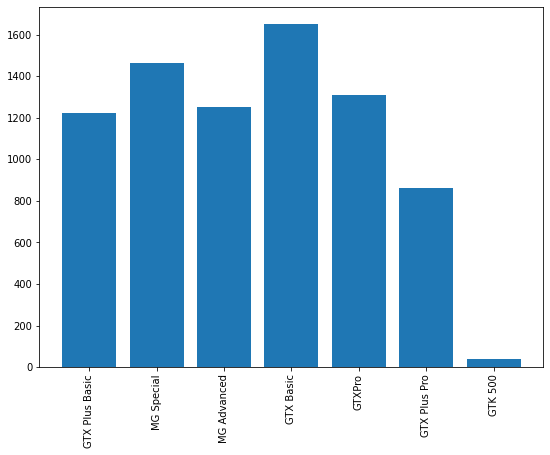

In [2]:
products = {}
for i in range(len(df)):
    if df.loc[i]['Product'] in products:
        products[df.loc[i]['Product']] += 1
    else:
        products[df.loc[i]['Product']] = 1

fig = plt.figure(1, [7, 5])
ax = fig.add_axes([0,0,1,1])
x_products = []
y_freqs = []
for key, value in products.items():
    x_products.append(key)
    y_freqs.append(value)
ax.bar(x_products, y_freqs)
plt.setp(ax.get_xticklabels(), rotation='vertical')
plt.show()

Now preprocessing the data:

In [3]:
def get_days_count(datetime):
    cnt = 0
    cnt += datetime.year * 365
    cnt += datetime.month * 30
    cnt += datetime.day
    return cnt

def preprocess(df, add_interval):
    # dropping unuseful columns
    df.drop('SalesAgentEmailID', inplace=True, axis=1)
    df.drop('ContactEmailID', inplace=True, axis=1)
    df.drop('Customer', inplace=True, axis=1)
    df.drop('Agent', inplace=True, axis=1)

    df['Stage'] = df['Stage'].replace(['Won'], int(1))
    df['Stage'] = df['Stage'].replace(['Lost'], int(0))

    df['Close_Value'].fillna(df['Close_Value'].mean(), inplace=True)
    
    if add_interval:
        intervals = []
        for i in range(len(df)):
            created_date = df.loc[i]['Created Date']
            close_date = df.loc[i]['Close Date']
            interval = get_days_count(close_date) - get_days_count(created_date)
            intervals.append(interval)

        df['Interval'] = intervals
        
    df.drop(['Created Date', 'Close Date'], inplace=True, axis = 1)
        
    return df

add_interval = True
df = preprocess(df, add_interval)
df.head()

,Stage,Product,Close_Value,Interval
0,1,GTX Plus Basic,1255.000000,140
1,1,MG Special,45.000000,298
2,0,MG Special,1852.915504,331
3,In Progress,MG Advanced,1054.000000,245
4,1,MG Advanced,3180.000000,24


In [4]:
def get_tagged_untagged_data(df):
    tagged_data, untagged_data = [x for _, x in df.groupby(df['Stage'] == 'In Progress')]
    return tagged_data, untagged_data

tagged_data, untagged_data = get_tagged_untagged_data(df)
tagged_data.head()

,Stage,Product,Close_Value,Interval
0,1,GTX Plus Basic,1255.000000,140
1,1,MG Special,45.000000,298
2,0,MG Special,1852.915504,331
4,1,MG Advanced,3180.000000,24
5,1,GTX Basic,517.000000,330


In [6]:
def split_train_test(df):
    separated_data = np.split(df, [round(len(df) * 0.8)], axis=0)
    return separated_data[0], separated_data[0]
    
def get_y(df):
    y = df['Stage']
    y = y.astype('int')
    return y

def split_numeric_categorical(df, add_interval):
    x_numerics = df.drop(['Stage', 'Product'], axis=1)
    x_numerics.reset_index(inplace=True, drop=True)
    if add_interval:
        x_categorical = df.drop(columns=['Stage', 'Close_Value', 'Interval'], axis=1)
    else:
        x_categorical = df.drop(columns=['Stage', 'Close_Value'], axis=1)
    return x_numerics, x_categorical

def one_hot_encode(numeric, categorical):
    enc = preprocessing.OneHotEncoder()
    enc.fit(categorical)
    encoded = enc.transform(categorical).toarray()
    encoded = pd.DataFrame(encoded)
    encoded = pd.concat([encoded, numeric], axis = 1)
    return encoded

train_data, test_data = split_train_test(tagged_data)
train_y = get_y(train_data)
test_y = get_y(test_data)
train_x_numerics, train_x_categorical = split_numeric_categorical(train_data, add_interval)
test_x_numerics, test_x_categorical = split_numeric_categorical(test_data, add_interval)

train_x_enc = one_hot_encode(train_x_numerics, train_x_categorical)
test_x_enc = one_hot_encode(test_x_numerics, test_x_categorical)

dt = DecisionTreeClassifier(max_depth = 5)
dt = dt.fit(train_x_enc, train_y)
result_dt = dt.predict(test_x_enc)
print("Decision Tree:")
print("accuracy: " + str(accuracy_score(test_y, result_dt)))
print("f1 score: " + str(f1_score(test_y, result_dt, average='macro')))
print("confusion matrix:\n" + str(confusion_matrix(test_y, result_dt)))
weight = {0: 0.5, 1: 1}
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True ,random_state=42, class_weight=weight)
rf = rf.fit(train_x_enc, train_y)
result_rf = rf.predict(test_x_enc)
print("\nRandom Forest:")
print("accuracy: " + str(accuracy_score(test_y, result_rf)))
print("f1 score: " + str(f1_score(test_y, result_rf, average='macro')))
print("confusion matrix:\n" + str(confusion_matrix(test_y, result_rf)))

nb = GaussianNB()
nb.fit(train_x_enc, train_y)
result_nb = nb.predict(test_x_enc)
print("\nNaive Bayes:")
print("accuracy: " + str(accuracy_score(test_y, result_nb)))
print("f1 score: " + str(f1_score(test_y, result_nb, average='macro')))
print("confusion matrix:\n" + str(confusion_matrix(test_y, result_nb)))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x_enc, train_y)
result_knn = knn.predict(test_x_enc)
print("\nKNN:")
print("accuracy: " + str(accuracy_score(test_y, result_knn)))
print("f1 score: " + str(f1_score(test_y, result_knn, average='macro')))
print("confusion matrix:\n" + str(confusion_matrix(test_y, result_knn)))

dump(rf, 'best_model.joblib')
pass

Decision Tree:
accuracy: 0.726854891661195
f1 score: 0.6224104967555223
confusion matrix:
[[ 459 1117]
 [ 131 2862]]

Random Forest:
accuracy: 0.9925585467279492
f1 score: 0.99172642329422
confusion matrix:
[[1543   33]
 [   1 2992]]

Naive Bayes:
accuracy: 0.6596629459400306
f1 score: 0.5614734718977241
confusion matrix:
[[ 426 1150]
 [ 405 2588]]

KNN:
accuracy: 0.8614576493762311
f1 score: 0.8464129176037145
confusion matrix:
[[1253  323]
 [ 310 2683]]


In [7]:
from joblib import load
BEST_MODEL_PATH = 'best_model.joblib'

def inference():
    '''
    df: a DataFrame
    result is the output of function which should be 
    something like: [0,1,1,1,0]
    0 -> Lost
    1 -> Won
    '''
    
    test = pd.read_excel('test.xls') # dependency: xlrd
    model = load(BEST_MODEL_PATH)
    
    add_interval = True
    df = preprocess(test, add_interval)
    
    test_y = get_y(test)
    
    test_x_numerics, test_x_categorical = split_numeric_categorical(df, add_interval)

    test_x_enc = one_hot_encode(test_x_numerics, test_x_categorical)

    result = model.predict(test_x_enc)
    print("accuracy: " + str(accuracy_score(test_y, result)))
    print("f1 score: " + str(f1_score(test_y, result, average='macro')))
    print("confusion matrix: \n" + str(confusion_matrix(test_y, result)))
    return result


inference()
pass

accuracy: 0.923
f1 score: 0.9228295304327259
confusion matrix: 
[[438  62]
 [ 15 485]]
